<a href="https://colab.research.google.com/github/vifirsanova/compling/blob/main/RBMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Курс "Компьютерная лингвистика" | НИУ ВШЭ Санкт-Петербург
2024 (c) В.И. Фирсанова
```

# Машинный перевод на основе правил

*Здесь и далее будет использовать аббревиатуру RBMT для обозначения машинного перевода на основе правил (Rule-Based Machine Translation)*

**Обзор**

- Формальное определение RBMT
  - основные компоненты RBMT
- Создаем самую простую модель RBMT
  - создаем базовую модель
  - добавляем правила
- Apertium
  - знакомство open-source платформой для RBMT
  - компоненты системы Apertium

## Формальное определение RBMT

**Машинный перевод:** преобразование последовательности `x` в последовательность `y`
---

**Разновидности RMBT**
---

Прямой перевод
---

**Определение:** *последовательное* (пошаговое, пословное, sequential) преобразование слов текста `x` в слова языка текста `y`

**Требования:**
- двуязычный словарь
- алгоритм преобразования слов `x` в слова `y` (сопоставление)

---

Трансферный перевод
---

**Определение:** преобразование с помощью *правил переноса* структуры языка текста `x` на структуры языка текста `y`

**Требования:**
- парсер, аннотатор [применяется к тексту `x`]
- правила переноса структуры `x` к виду `y` [применяются к разметке текста `x`]
- генератор [применяется к преобразованной разметке `x --> y`]

---

Interlingua
---

**Определение:** преобразование структуры `x` к виду абстрактного представления - *интерлингвы* - и генерация структуры `y` на ее основе.

**Требования:**
- анализатор [применяется к тексту `x`]
- абстрактное представление, интерлингва
- генератор [применяется к интерлингве]

*Рекомендуемое чтение: Speech and Language Processing: An introduction to natural language processing, computational linguistics, and speech recognition. Daniel Jurafsky & James H. Martin. 2007. Глава 25, раздел 25.2 CLASSICAL MT & THE VAUQUOIS TRIANGLE*

## Основные компоненты RBMT

1. **Анализ:** парсинг, аннотация, разметка
2. **Трансфер:** применение правил к размеченной структуре
3. **Генерация:** преобразование структуры к виду текста

Уровни анализа и виды разметки для разных систем RBMT:

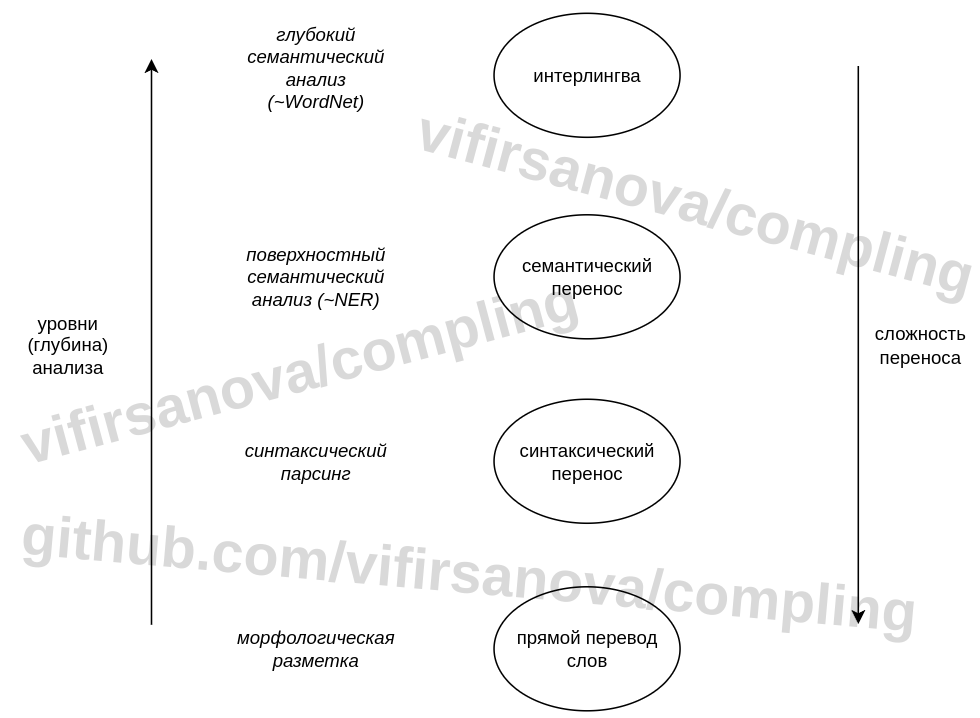



## DIY-модель

### Прямой перевод

Представим, что мы в штаб-квартире IBM! Повторим Джорджтаунский эксперимент

In [ ]:
class DirectTranslationModel:
    def __init__(self):
        # двуязычный лексикон (можно расширять!)
        self.bilingual_dict = {
            'today': 'heute',
            'she': 'sie',
            'is': 'ist',
            'happy': 'glücklich',
            }

        # список глаголов для морфологического анализа (можно дополнять)
        self.verbs = {
            'be',
            'is',
            'was',
            }

    def shallow_morphological_analysis(self, source_text):
        # токенизация исходного текста (можно дополнить любым другим методом предобработки)
        source_tokens = source_text.lower().split()

        # упрощенная частеречная разметка: создаем список меток (можно заменить PoS-теггером)
        self.pos_tags = ['V' if word in self.verbs else '' for word in source_tokens]

        return source_tokens, self.pos_tags

    def lexical_transfer(self, source_tokens):
        # ищем соответствия в двуязычном лексиконе
        target_tokens = [self.bilingual_dict.get(word, word) for word in source_tokens]
        return target_tokens

    def local_reordering(self, target_tokens):
        # меняем порядок слов для немецкого языка: если это глагол, отправляем его на позицию #2
        for i in range(len(target_tokens)):
            if 'V' == self.pos_tags[i]:  # ищем в списке тегов 'V'
                # перемещаем в списке токенов найденное на второе место
                target_tokens.insert(1, target_tokens.pop(i))

        return target_tokens

    def morphological_generation(self, target_tokens):
        # упрощенная генерация: склеиваем токены в строку
        return ' '.join(target_tokens).capitalize()  # первое слово в предложении пишем с большой буквы

    def translate(self, source_text):
        # шаг 1: морфологический анализ
        source_tokens, pos_tags = self.shallow_morphological_analysis(source_text)

        # шаг 2: лексический трансфер
        _target_tokens = self.lexical_transfer(source_tokens)

        # шаг 3: меняем порядок слов
        target_tokens = self.local_reordering(_target_tokens)

        # шаг 4: генерация
        result = self.morphological_generation(target_tokens)

        # шаг 5: вывод промежуточных результатов для интерпретации
        print("Исходный текст:", source_text)
        print("Его токены:", source_tokens)
        print("Частересные теги:", pos_tags)
        print("Лексические соответствия:", _target_tokens)
        print("Верный порядок слов:", target_tokens)
        print("Сгенерированный результат:", result)

# инициализация класса
translator = DirectTranslationModel()

# переводим текст 'Today she is happy' на немецкий
translator.translate("Today she is happy")

Исходный текст: Today she is happy
Его токены: ['today', 'she', 'is', 'happy']
Частересные теги: ['', '', 'V', '']
Лексические соответствия: ['heute', 'ist', 'sie', 'glücklich']
Верный порядок слов: ['heute', 'ist', 'sie', 'glücklich']
Сгенерированный результат: Heute ist sie glücklich


**Дискуссия:** какие правила для пары английский-немецкий мы можем добавить в эту модель? В чем недостатки такой модели?

### Трансферная модель

Дополним нашу модель *контрастивными знаниями* о том, как языки различаются структурно.

**Пример синтаксической трансформации:** Adj-Noun --> Noun-Adj

**Пример лексической трансформации:** home --> Hemait, home --> nach Hause

NB!

1. Нам может понадобиться лингвоспецифическая токенизация: [*John saw the girl*] [*with the binoculars*]
2. Чтобы уменьшить количество лексических трансформаций, нужно разрешить неоднозначность

In [ ]:
class TransferTranslationModel:
    def __init__(self):
        # двуязычный лексикон (можно расширять!)
        self.bilingual_dict = {
            'today': 'heute',
            'she': 'sie',
            'is': 'ist',
            'happy': 'glücklich',
            'at': 'nach',
            'home': ('Heimat', 'Hause') # 2 варианта перевода
            }

        # список глаголов для морфологического анализа (можно дополнять)
        self.verbs = {
            'be',
            'is',
            'was',
            }

        # список существительных
        self.nouns = {
            'home',
            }

    def analysis(self, source_text):
        # токенизация исходного текста (можно дополнить любым другим методом предобработки)
        source_tokens = source_text.replace('.', '').lower().split()
        # упрощенная частеречная разметка: создаем список меток (можно заменить PoS-теггером)
        self.pos_tags = ['V' if word in self.verbs else 'N' if word in self.nouns else '' for word in source_tokens]

        return source_tokens, self.pos_tags

    def transfer(self, source_tokens):
        target_tokens = []
        # правила лексической замены
        for i in range(len(source_tokens)):
            if source_tokens[i] == 'home':
                if source_tokens[i-1] == 'at':  # проверяем сочетаемость слова 'home'
                    target_tokens.append(self.bilingual_dict.get(source_tokens[i], source_tokens[i])[1]) # выбираем значение #2
                else:
                    target_tokens.append(self.bilingual_dict.get(source_tokens[i], source_tokens[i])[0]) # выбираем значение #1
            else:
                target_tokens.append(self.bilingual_dict.get(source_tokens[i], source_tokens[i]))
        # правила синтаксической замены
        # меняем порядок слов для немецкого языка: если это глагол, отправляем его на позицию #2
        for i in range(len(target_tokens)):
            if 'V' == self.pos_tags[i]:  # ищем в списке тегов 'V'
                # перемещаем в списке токенов найденное на второе место
                target_tokens.insert(1, target_tokens.pop(i))
            if 'N' == self.pos_tags[i]:
                # существительные - с большой буквы
                target_tokens[i] = target_tokens[i].capitalize()

        return target_tokens

    def generation(self, target_tokens):
        # упрощенная генерация: склеиваем токены в строку
        result = ' '.join(target_tokens)
        return result[0].upper() + result[1:] + '.' # первое слово в предложении - с большой буквы, ставим точку

    def translate(self, source_text):
        # шаг 1: анализ
        source_tokens, pos_tags = self.analysis(source_text)

        # шаг 2: трансфер
        target_tokens = self.transfer(source_tokens)

        # шаг 4: генерация
        result = self.generation(target_tokens)

        # шаг 5: вывод промежуточных результатов для интерпретации
        print("Исходный текст:", source_text)
        print("Его токены:", source_tokens)
        print("Результат анализа (теги):", pos_tags)
        print("Результат трансфера:", target_tokens)
        print("Результат генерации:", result)

# инициализация класса
translator = TransferTranslationModel()

# переводим текст 'Today she is happy at home.' на немецкий
translator.translate("Today she is happy at home.")

Исходный текст: Today she is happy at home.
Его токены: ['today', 'she', 'is', 'happy', 'at', 'home']
Результат анализа (теги): ['', '', 'V', '', '', 'N']
Результат трансфера: ['heute', 'ist', 'sie', 'glücklich', 'nach', 'Hause']
Результат генерации: Heute ist sie glücklich nach Hause.


**Дискуссия:** какие компоненты анализа можно добавить в нашу модель? Что можно автоматизировать, а что нужно прописать вручную?

### Интерлингва

Идея в том, чтобы создать *представление* текста, описать его на концептуальном уровне:

| | |
-------|-------|
|AGENT| 3 SG |
|TENSE | PRAES|
|ATTRIBUTE| MOOD-HAPPY|
|LOCATION|INSIDE-HOME|

**Дискуссия:** какие уровни языка мы можем описать? Какие ограничения будут у такой модели?

## Apertium

Что такое Apertium?

### APY Apertium

Что такое APY?

Переводим с помощью APY

### Компоненты Apertium

Анализатор

In [ ]:
# запускаем

Как работает анализатор?

Генератор

In [ ]:
# запускаем

Как работает генератор?

Теггер

In [ ]:
# запускаем

Как работает теггер?

Перевод

In [ ]:
# запускаем

Как работает перевод?

# Домашнее задание

Представьте, что вы работаете аналитиком в проекте по разработке системы машинного перевода. Ваша команда создает систему машинного перевода на основе правил. Прежде чем ваши коллеги приступят к разработке системы, вам, как аналитику, нужно описать архитектуру будущей системы.

Опишите структуру своей системы машинного перевода на основе правила в формате псевдокода, алгоритма или блок-схемы (на выбор). В процессе работы вам нужно будет ответить на следующие вопросы:

+ Какую языковую пару обрабатывает ваша система?
+ Какие виды анализа и предварительной обработки данных вы применяете?
+ Какие языковые правила вам нужно описать?
+ Как ваша система будет генерировать результат, т.е. перевод?

Дополнительно попробуйте ответить на вопрос:

+ Какие библиотеки NLP вы будете использовать?

Образец алгоритма

```
1. принимаем на вход текст пользователя
...
4. сегментация текста
...
7. лексический трансфер
  7.1. ...
  ...
8. генерация слов
9. вывод на экран перевода текста
```

Образец псевдокода

```
function analyze_text(text):
    # использует SpaCy для частеречной разметки
    analyzed_text = []
    для каждого слова в тексте:
        извлекаем тег
        записываем в analyzed_text
    return analyzed_text
```

Образец блок-схемы

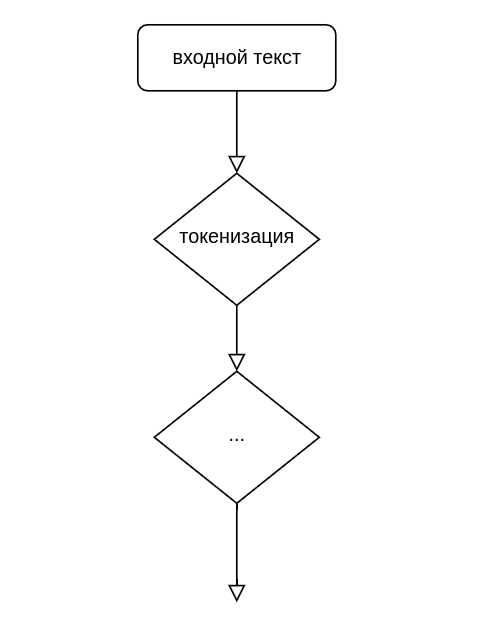